In [1]:
import warnings
warnings.filterwarnings('ignore')
import csv
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sys
import os
import shutil
import glob

# V4 (90 surveys) - Data plot 06/08/2024. Updated with long tail 02/24/2025

## 1. Path to data

In [2]:
uniform_folder = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/baseline/"
enrich_folder = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/enrich_tail/"
long_tail_folder = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/long_tail/"

surveys = ["survey_1", "survey_2", "survey_3","survey_4","survey_5",]

## 2. Process db into csv

In [3]:
def convert_csv(db_path, output_file):
    """
    Convert the user response from db into csv file

    :param db_path: Database for user response

    :return:
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("select * from Responses;")

    with open(output_file, "w", newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # write headers
        csv_writer.writerow([i[0] for i in cursor.description])

        # write content
        csv_writer.writerows(cursor)

In [8]:
csv_save_dir = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/"

In [10]:
for one_survey in surveys:
    
#     convert_csv(os.path.join(uniform_folder, one_survey + "_baseline.db"),
#                os.path.join(csv_save_dir, one_survey + "_baseline.csv"))
    
#     convert_csv(os.path.join(enrich_folder, one_survey + "_enrich.db"),
#                os.path.join(csv_save_dir, one_survey + "_enrich.csv"))
    
    convert_csv(os.path.join(long_tail_folder, one_survey + "_long.db"),
               os.path.join(csv_save_dir, one_survey + "_long.csv"))

In [11]:
def combine_csv(csv_dir, save_dir, data_type):
    allFiles = glob.glob(csv_dir + "/*_" + data_type + ".csv")
    allFiles.sort()
    
    with open(save_dir + "/" + data_type + '.csv', 'wb') as outfile:
        for i, fname in enumerate(allFiles):
            with open(fname, 'rb') as infile:
                if i != 0:
                    infile.readline()  # Throw away header on all but first file
                # Block copy rest of file from input to output without parsing
                shutil.copyfileobj(infile, outfile)
                print(fname + " has been imported.")

In [12]:
# combine_csv(csv_dir=csv_save_dir, 
#             save_dir=csv_save_dir, 
#             data_type="baseline")

# combine_csv(csv_dir=csv_save_dir, 
#             save_dir=csv_save_dir, 
#             data_type="enrich")

combine_csv(csv_dir=csv_save_dir, 
            save_dir=csv_save_dir, 
            data_type="long")

/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/survey_1_long.csv has been imported.
/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/survey_2_long.csv has been imported.
/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/survey_3_long.csv has been imported.
/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/survey_4_long.csv has been imported.
/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/survey_5_long.csv has been imported.


## 3. Plot overall curve

In [16]:
uniform_csv = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/baseline.csv"
enrich_csv = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/enrich.csv"
long_csv = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/long.csv"

In [17]:
uniform_data = pd.read_csv(uniform_csv)
enrich_data = pd.read_csv(enrich_csv)
long_data = pd.read_csv(long_csv)

In [20]:
def add_img_name_column(df):
    """
    Add a row of test image names in original dataframe
    """
    # find test img index
    # Add a column for test img names
    df['test_img_name'] = df.test_img.str. \
                            split('/').str[-1].str.split("_").str[-1].str.split(".").str[0]

    # Only take the columns we need
    df = df[["worker_response", "test_img_name", "ResponseTime"]]
    df["test_img_name"] = df["test_img_name"].astype(int)
    df = df.sort_values(by=["test_img_name"])
    df["ResponseTime"] = df["ResponseTime"].astype(int)
    df["ResponseTime"] = df["ResponseTime"]/1000
    
    return df

In [23]:
uniform_results = add_img_name_column(uniform_data)
enrich_results = add_img_name_column(enrich_data)
long_results = add_img_name_column(long_data)

In [24]:
uniform_results_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/uniform_results.csv"
enrich_results_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/enrich_results.csv"
long_results_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_results/raw_data/csv_files/long_results.csv"

uniform_results.to_csv(uniform_results_path)
enrich_results.to_csv(enrich_results_path)
long_results.to_csv(long_results_path)

In [27]:
def generate_per_frame_response(response_csv_path):
    data = pd.read_csv(response_csv_path)
    
    # Take the columns we need
    data_selected = data[["worker_response", "test_img_name", "ResponseTime"]]
    data_selected.columns = ["worker_response", "frame_index", "ResponseTime"]
    
    data_final = data_selected

    
    # Get the avg RT for each frame
    rt_frame = data_final[["frame_index", "ResponseTime"]]
    rt_frame = rt_frame.groupby(["frame_index"]).sum()
    #print(rt_frame)
    
    # Group by frame index: 
    # response: get counts
    grouped = data_final.groupby(['frame_index','worker_response']).worker_response. \
                            agg('count').to_frame('count').reset_index()
    #print(grouped.head(10))
    
    # responses: get total counts
    grouped_for_counts = grouped[['frame_index','count']]
    total_counts = grouped_for_counts.groupby(['frame_index']).sum()
    #print(total_counts)
    
    # responses: select the counts where worker response is 2
    worker_response_selected = grouped[grouped['worker_response'] == 2]
    worker_response_selected.columns = ["frame_index", "worker_response", "person_b_counts"]
    worker_response_selected = worker_response_selected[["frame_index", "worker_response", "person_b_counts"]]
    
    person_b_counts = worker_response_selected[["frame_index", "person_b_counts"]]
    #print(worker_response_selected)
    
    # responses: merge two frames
    result_df = pd.merge(total_counts, person_b_counts, on="frame_index")
    result_df = pd.merge(result_df, rt_frame, on="frame_index")
    #print(result_df)
    
    # response: convert to probability of choosing person B as the answer
    result_df["prob_b"] = result_df["person_b_counts"]/result_df["count"]
    result_df["avg_rt"] = result_df["ResponseTime"]/(result_df["count"]*1000)
    
    return result_df

In [28]:
uniform_per_frame = generate_per_frame_response(uniform_results_path)
enrich_per_frame = generate_per_frame_response(enrich_results_path)
long_per_frame = generate_per_frame_response(long_results_path)

In [29]:
def post_process_results(df):
    """
    """
    
    df = df[["frame_index", "prob_b"]]
    df = df.set_index('frame_index')
    
    return df

In [31]:
uniform_final = post_process_results(uniform_per_frame)
enrich_final = post_process_results(enrich_per_frame)
long_final = post_process_results(long_per_frame)

In [32]:
uniform_final.columns = ["uniform"]
enrich_final.columns = ["enrich"]
long_final.columns = ["long"]

all_data = uniform_final.join(enrich_final).join(long_final)

In [33]:
all_data

,uniform,enrich,long
frame_index,,,
36,0.074786,0.119048,0.065728
38,0.057692,0.062907,0.018824
40,0.066239,0.075922,0.009412
42,0.104701,0.097614,0.011765
45,0.123932,0.132321,0.023585
47,0.188034,0.201735,0.030660
50,0.258547,0.288503,0.042453
52,0.388889,0.392625,0.058962
55,0.485043,0.496746,0.096698


<AxesSubplot:xlabel='frame_index'>

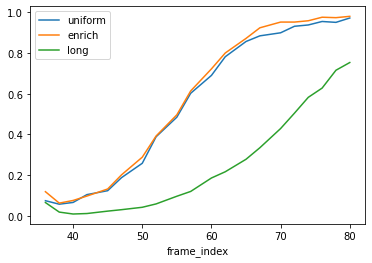

In [34]:
all_data.plot()

In [37]:
print(list(all_data["long"]))

[0.06572769953051644, 0.018823529411764704, 0.009411764705882352, 0.011764705882352941, 0.02358490566037736, 0.030660377358490566, 0.04245283018867924, 0.0589622641509434, 0.09669811320754718, 0.12028301886792453, 0.18632075471698112, 0.2169811320754717, 0.2783018867924528, 0.33490566037735847, 0.42924528301886794, 0.5047169811320755, 0.5825471698113207, 0.6279620853080569, 0.7156398104265402, 0.7535545023696683]


<AxesSubplot:xlabel='frame_index'>

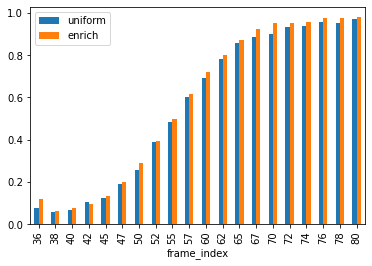

In [24]:
all_data.plot.bar()

## Plot for each survey

# V3 (6 survey) - Data Plot 04/01/2024 : Plot per morph

## 1. Find all the morphs

In [8]:
uniform_data.head(5)

,AssignmentId,survey_index,date_time,class_A_imgs,class_B_imgs,worker_response,ImposterFound,test_img,ResponseTime
120,lngftldu,0,"03/20/2024, 20:54:27",face_morph_300_enriched_tail/normal_quests/Ain...,face_morph_300_enriched_tail/normal_quests/Ain...,1,0,face_morph_300_enriched_tail/normal_quests/Ain...,4562
121,lngftldu,0,"03/20/2024, 20:54:29",face_morph_300_enriched_tail/normal_quests/Ain...,face_morph_300_enriched_tail/normal_quests/Ain...,2,0,face_morph_300_enriched_tail/normal_quests/Ain...,1201
122,lngftldu,0,"03/20/2024, 20:54:31",face_morph_300_enriched_tail/normal_quests/Ain...,face_morph_300_enriched_tail/normal_quests/Ain...,2,0,face_morph_300_enriched_tail/normal_quests/Ain...,984
123,lngftldu,0,"03/20/2024, 20:54:32",face_morph_300_enriched_tail/normal_quests/Ain...,face_morph_300_enriched_tail/normal_quests/Ain...,1,0,face_morph_300_enriched_tail/normal_quests/Ain...,1163
124,lngftldu,0,"03/20/2024, 20:54:34",face_morph_300_enriched_tail/normal_quests/Ain...,face_morph_300_enriched_tail/normal_quests/Ain...,2,0,face_morph_300_enriched_tail/normal_quests/Ain...,973


In [9]:
all_morphs = uniform_data['class_A_imgs'].unique()
# all_morphs = ["face_morph_300_enriched_tail/normal_quests/Alexa_Vega_to_Kevin_Keegan/morph_img_0001.jpg"]

print(all_morphs)

['face_morph_300_enriched_tail/normal_quests/Ainsworth_Dyer_to_Claudio_Abbado/morph_img_0001.jpg'
 'face_morph_300_enriched_tail/normal_quests/Alberto_Acosta_to_Robert_Tyrrell/morph_img_0001.jpg'
 'face_morph_300_enriched_tail/normal_quests/Alexa_Vega_to_Kevin_Keegan/morph_img_0001.jpg'
 'face_morph_300_enriched_tail/normal_quests/Aline_Chretien_to_Perry_Gibbs/morph_img_0002.jpg'
 'face_morph_300_enriched_tail/normal_quests/Angel_Maza_to_Susan_Walvius/morph_img_0001.jpg'
 'face_morph_300_enriched_tail/normal_quests/Ben_Chandler_to_Denys_Arcand/morph_img_0001.jpg']


## 2. Loop each morph and plot

face_morph_300_enriched_tail/normal_quests/Ainsworth_Dyer_to_Claudio_Abbado/morph_img_0001.jpg
face_morph_300_enriched_tail/normal_quests/Alberto_Acosta_to_Robert_Tyrrell/morph_img_0001.jpg
face_morph_300_enriched_tail/normal_quests/Alexa_Vega_to_Kevin_Keegan/morph_img_0001.jpg
face_morph_300_enriched_tail/normal_quests/Aline_Chretien_to_Perry_Gibbs/morph_img_0002.jpg
face_morph_300_enriched_tail/normal_quests/Angel_Maza_to_Susan_Walvius/morph_img_0001.jpg
face_morph_300_enriched_tail/normal_quests/Ben_Chandler_to_Denys_Arcand/morph_img_0001.jpg


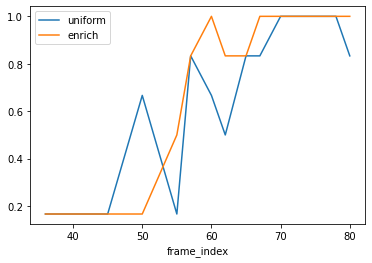

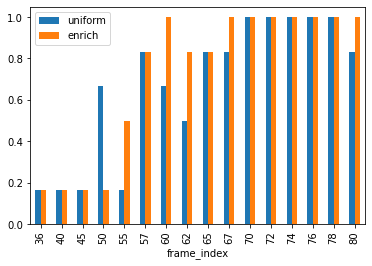

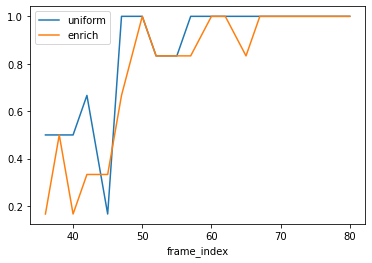

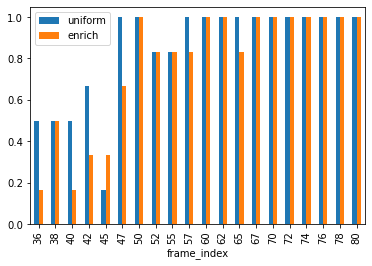

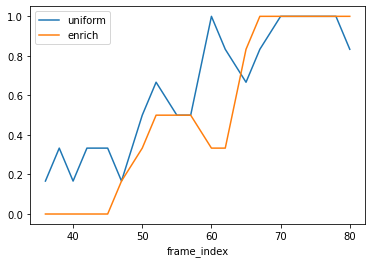

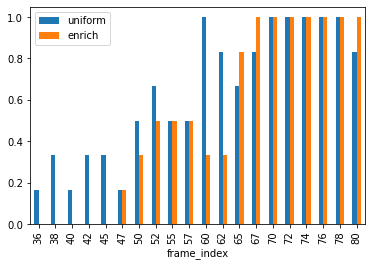

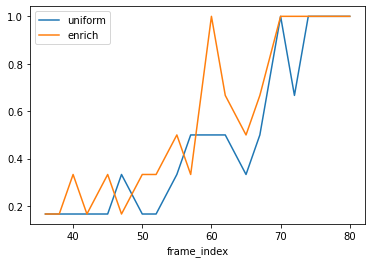

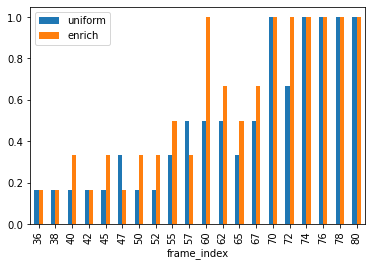

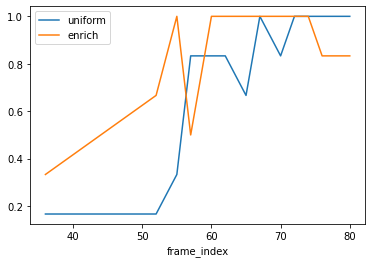

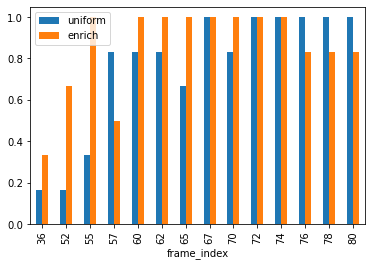

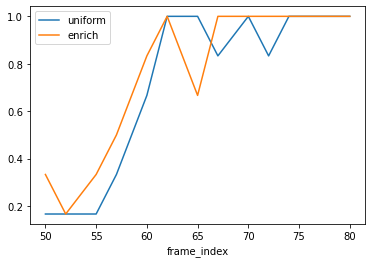

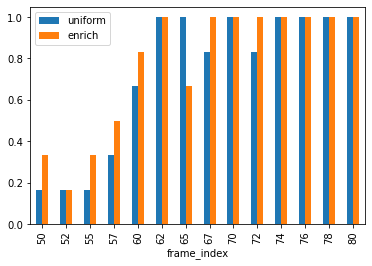

In [17]:
for one_morph in all_morphs:
    print(one_morph)
    
    # Find all the submissions for this morph
    one_morph_uniform = uniform_data.loc[uniform_data['class_A_imgs'] == one_morph]
    one_morph_enrich = enrich_data.loc[enrich_data['class_A_imgs'] == one_morph]

    
    # Add column for test image names
    one_uniform_results = add_img_name_column(one_morph_uniform)
    one_enrich_results = add_img_name_column(one_morph_enrich)
    
#     print(one_enrich_results)
    
    # Create per-frame results
    one_uniform_per_frame = generate_per_frame_response_w_data(one_uniform_results)
    one_enrich_per_frame = generate_per_frame_response_w_data(one_enrich_results)
    
    # Post process
    one_uniform_final = post_process_results(one_uniform_per_frame)
    one_enrich_final = post_process_results(one_enrich_per_frame)
    
    
    one_uniform_final.columns = ["uniform"]
    one_enrich_final.columns = ["enrich"]
    
    # Plot
    one_data = one_uniform_final.join(one_enrich_final)
    
    one_data = one_data.fillna(0)
    
    one_data.plot()
    
    one_data.plot.bar()

# V3 (6 survey) - Data Plot 03/28/2024

In [2]:
uniform_db_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_6_v3/uniform.db"
enrich_db_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_6_v3/enrich_tail.db"

# uniform_id = ["yyckrtzi", "lngftldu", "fgvowiax", 
#               "bynzrbtw", "efdaxwun", "krpfunzk", "htrtvyca"]
# enrich_id = ["yaqautvp", "dlhhkrml", "jmasmexb", 
#              "akcvcnwg", "xjcnyfhd", "bjjluxwg", "hcnohwpb"]

uniform_id = ["lngftldu", "fgvowiax", 
              "bynzrbtw", "efdaxwun", "krpfunzk", "htrtvyca"]
enrich_id = ["dlhhkrml", "jmasmexb", 
             "akcvcnwg", "xjcnyfhd", "bjjluxwg", "hcnohwpb"]

## 1. Covert DB record to CSV

In [4]:
def convert_csv(db_path, output_file):
    """
    Convert the user response from db into csv file

    :param db_path: Database for user response

    :return:
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("select * from Responses;")

    with open(output_file, "w", newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # write headers
        csv_writer.writerow([i[0] for i in cursor.description])

        # write content
        csv_writer.writerows(cursor)

In [5]:
uniform_csv = "/Users/kiyoshi/Desktop/jov_everything/face_morph_6_v3/uniform.csv"
enrich_csv = "/Users/kiyoshi/Desktop/jov_everything/face_morph_6_v3/enrich.csv"

convert_csv(uniform_db_path, uniform_csv)
convert_csv(enrich_db_path, enrich_csv)

## 2. Overall Plot - all morphs and all participants

In [6]:
uniform_data = pd.read_csv(uniform_csv)
enrich_data = pd.read_csv(enrich_csv)

print(uniform_data.shape, enrich_data.shape)

(840, 9) (840, 9)


In [7]:
uniform_data = uniform_data.loc[uniform_data['AssignmentId'].isin(uniform_id)]
enrich_data = enrich_data.loc[enrich_data['AssignmentId'].isin(enrich_id)]

## 2.1 Add a column of test img name and save results to file

In [19]:
def add_img_name_column(df):
    """
    Add a row of test image names in original dataframe
    """
    # find test img index
    # Add a column for test img names
    df['test_img_name'] = df.test_img.str. \
                            split('/').str[-1].str.split("_").str[-1].str.split(".").str[0]

    # Only take the columns we need
    df = df[["worker_response", "test_img_name", "ResponseTime"]]
    df["test_img_name"] = df["test_img_name"].astype(int)
    df = df.sort_values(by=["test_img_name"])
    df["ResponseTime"] = df["ResponseTime"].astype(int)
    df["ResponseTime"] = df["ResponseTime"]/1000
    
    return df

In [11]:
uniform_results = add_img_name_column(uniform_data)
enrich_results = add_img_name_column(enrich_data)

In [12]:
uniform_results_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_6_v3/uniform_results.csv"
enrich_results_path = "/Users/kiyoshi/Desktop/jov_everything/face_morph_6_v3/enrich_results.csv"

uniform_results.to_csv(uniform_results_path)
enrich_results.to_csv(enrich_results_path)

## 2.2 Generate DF for per-test-image response

In [26]:
def generate_per_frame_response(response_csv_path):
    data = pd.read_csv(response_csv_path)
    
    # Take the columns we need
    data_selected = data[["worker_response", "test_img_name", "ResponseTime"]]
    data_selected.columns = ["worker_response", "frame_index", "ResponseTime"]
    
    data_final = data_selected

    
    # Get the avg RT for each frame
    rt_frame = data_final[["frame_index", "ResponseTime"]]
    rt_frame = rt_frame.groupby(["frame_index"]).sum()
    #print(rt_frame)
    
    # Group by frame index: 
    # response: get counts
    grouped = data_final.groupby(['frame_index','worker_response']).worker_response. \
                            agg('count').to_frame('count').reset_index()
    #print(grouped.head(10))
    
    # responses: get total counts
    grouped_for_counts = grouped[['frame_index','count']]
    total_counts = grouped_for_counts.groupby(['frame_index']).sum()
    #print(total_counts)
    
    # responses: select the counts where worker response is 2
    worker_response_selected = grouped[grouped['worker_response'] == 2]
    worker_response_selected.columns = ["frame_index", "worker_response", "person_b_counts"]
    worker_response_selected = worker_response_selected[["frame_index", "worker_response", "person_b_counts"]]
    
    person_b_counts = worker_response_selected[["frame_index", "person_b_counts"]]
    #print(worker_response_selected)
    
    # responses: merge two frames
    result_df = pd.merge(total_counts, person_b_counts, on="frame_index")
    result_df = pd.merge(result_df, rt_frame, on="frame_index")
    #print(result_df)
    
    # response: convert to probability of choosing person B as the answer
    result_df["prob_b"] = result_df["person_b_counts"]/result_df["count"]
    result_df["avg_rt"] = result_df["ResponseTime"]/(result_df["count"]*1000)
    
    return result_df

In [61]:
uniform_per_frame = generate_per_frame_response(uniform_results_path)
enrich_per_frame = generate_per_frame_response(enrich_results_path)

## 2.3 Post-process: reset index and etc

In [19]:
def post_process_results(df):
    """
    """
    
    df = df[["frame_index", "prob_b"]]
    df = df.set_index('frame_index')
    
    return df

In [63]:
uniform_final = post_process_results(uniform_per_frame)
enrich_final = post_process_results(enrich_per_frame)

## 2.4 Plot 

In [64]:
uniform_final.columns = ["uniform"]
enrich_final.columns = ["enrich"]

In [65]:
all_data = uniform_final.join(enrich_final)

<AxesSubplot:xlabel='frame_index'>

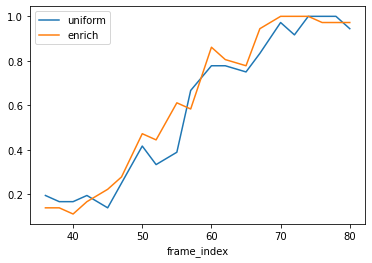

In [66]:
all_data.plot()

<AxesSubplot:xlabel='frame_index'>

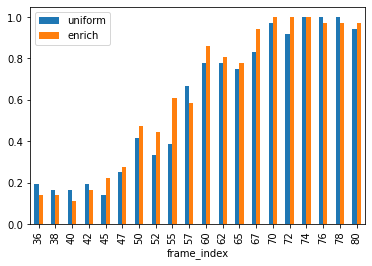

In [67]:
all_data.plot.bar()

In [23]:
all_data

,uniform,enrich
frame_index,,
36,0.190476,0.119048
38,0.190476,0.119048
40,0.166667,0.095238
42,0.190476,0.142857
45,0.142857,0.190476
47,0.238095,0.238095
50,0.428571,0.404762
52,0.357143,0.404762
55,0.452381,0.523810


## 3. Plot per-morph plots

In [15]:
def generate_per_frame_response_w_data(data):
    # Take the columns we need
    data_selected = data[["worker_response", "test_img_name", "ResponseTime"]]
    data_selected.columns = ["worker_response", "frame_index", "ResponseTime"]
    
    data_final = data_selected

    
    # Get the avg RT for each frame
    rt_frame = data_final[["frame_index", "ResponseTime"]]
    rt_frame = rt_frame.groupby(["frame_index"]).sum()
    #print(rt_frame)
    
    # Group by frame index: 
    # response: get counts
    grouped = data_final.groupby(['frame_index','worker_response']).worker_response. \
                            agg('count').to_frame('count').reset_index()
    #print(grouped.head(10))
    
    # responses: get total counts
    grouped_for_counts = grouped[['frame_index','count']]
    total_counts = grouped_for_counts.groupby(['frame_index']).sum()
    #print(total_counts)
    
    # responses: select the counts where worker response is 2
    worker_response_selected = grouped[grouped['worker_response'] == 2]
    worker_response_selected.columns = ["frame_index", "worker_response", "person_b_counts"]
    worker_response_selected = worker_response_selected[["frame_index", "worker_response", "person_b_counts"]]
    
    person_b_counts = worker_response_selected[["frame_index", "person_b_counts"]]
    #print(worker_response_selected)
    
    # responses: merge two frames
    result_df = pd.merge(total_counts, person_b_counts, on="frame_index")
    result_df = pd.merge(result_df, rt_frame, on="frame_index")
    #print(result_df)
    
    # response: convert to probability of choosing person B as the answer
    result_df["prob_b"] = result_df["person_b_counts"]/result_df["count"]
    result_df["avg_rt"] = result_df["ResponseTime"]/(result_df["count"]*1000)
    
    return result_df

# Old - Data analysis 03/07/2024

In [28]:
database_path = ["/Users/kiyoshi/Desktop/jov_everything/24_survey/memeTurkWork.db",
                "/Users/kiyoshi/Desktop/jov_everything/24_survey/memeTurkWork_wrong_indexing.db",
                "/Users/kiyoshi/Desktop/jov_everything/24_survey/memeTurkWork_myself_4.db"]
raw_csv_save_path = "/Users/kiyoshi/Desktop/jov_everything/24_survey/combine_3_db.csv"

In [29]:
worker_id_uniform = ["tpcmympo", "xbnwovwi", "jlflqtkp", "cpjqwncf"]
worker_id_enrich = ["odpavqyq", "mkzyngfl", "qtcbfunj", 
                    "rxvkdfak", "qevypgjf", "jmdnxpau"]

In [30]:
with open(raw_csv_save_path, "w", newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    for one_db in database_path:
        conn = sqlite3.connect(one_db)
        cursor = conn.cursor()
        cursor.execute("select * from Responses;")

        # write headers
        csv_writer.writerow([i[0] for i in cursor.description])

        # write content
        csv_writer.writerows(cursor)

In [31]:
raw_data = pd.read_csv(raw_csv_save_path)

In [32]:
raw_data.shape

(1906, 9)

In [33]:
# Find answers for uniform
uniform_record = raw_data.loc[raw_data['AssignmentId'].isin(worker_id_uniform)]

In [34]:
uniform_record.shape

(480, 9)

In [35]:
uniform_record.head(3)

,AssignmentId,survey_index,date_time,class_A_imgs,class_B_imgs,worker_response,ImposterFound,test_img,ResponseTime
0,cpjqwncf,2,"02/29/2024, 22:13:27",face_morph_300_enriched_tail/normal_quests/Chi...,face_morph_300_enriched_tail/normal_quests/Chi...,1,0,face_morph_300_enriched_tail/normal_quests/Chi...,7483
1,cpjqwncf,2,"02/29/2024, 22:13:34",face_morph_300_enriched_tail/normal_quests/Chi...,face_morph_300_enriched_tail/normal_quests/Chi...,1,0,face_morph_300_enriched_tail/normal_quests/Chi...,5922
2,cpjqwncf,2,"02/29/2024, 22:13:44",face_morph_300_enriched_tail/normal_quests/Chi...,face_morph_300_enriched_tail/normal_quests/Chi...,1,0,face_morph_300_enriched_tail/normal_quests/Chi...,9439


In [36]:
# find answers for enrich
enrich_record = raw_data.loc[raw_data['AssignmentId'].isin(worker_id_enrich)]

In [37]:
enrich_record.shape

(720, 9)

In [38]:
# find test img index
# Add a column for test img names
uniform_record['test_img_name'] = uniform_record.test_img.str. \
split('/').str[-1].str.split("_").str[-1].str.split(".").str[0]

# Only take the columns we need
uniform_record = uniform_record[["worker_response", "test_img_name", "ResponseTime"]]
uniform_record["test_img_name"] = uniform_record["test_img_name"].astype(int)
uniform_record = uniform_record.sort_values(by=["test_img_name"])
uniform_record["ResponseTime"] = uniform_record["ResponseTime"].astype(int)
uniform_record["ResponseTime"] = uniform_record["ResponseTime"]/1000

In [39]:
uniform_record

,worker_response,test_img_name,ResponseTime
16,1,36,2.369
353,1,36,1.279
161,1,36,1.574
74,1,36,6.453
194,1,36,0.996
...,...,...,...
369,2,80,7.622
425,2,80,3.465
191,2,80,2.901
387,2,80,10.239


In [40]:
# find test img index
# Add a column for test img names
enrich_record['test_img_name'] = enrich_record.test_img.str. \
split('/').str[-1].str.split("_").str[-1].str.split(".").str[0]

# Only take the columns we need
enrich_record = enrich_record[["worker_response", "test_img_name", "ResponseTime"]]
enrich_record["test_img_name"] = enrich_record["test_img_name"].astype(int)
enrich_record = enrich_record.sort_values(by=["test_img_name"])
enrich_record["ResponseTime"] = enrich_record["ResponseTime"].astype(int)
enrich_record["ResponseTime"] = enrich_record["ResponseTime"]/1000

In [41]:
enrich_record

,worker_response,test_img_name,ResponseTime
975,1,36,1.158
1303,2,36,3.350
629,2,36,0.964
1278,2,36,1.580
1381,1,36,1.588
...,...,...,...
824,2,80,3.407
977,2,80,1.514
1141,2,80,0.787
1358,2,80,1.258


In [42]:
uniform_record.to_csv("/Users/kiyoshi/Desktop/jov_everything/24_survey/uniform_record.csv")
enrich_record.to_csv("/Users/kiyoshi/Desktop/jov_everything/24_survey/enrich_record.csv")

In [43]:
def generate_per_frame_response(response_csv_path):
    data = pd.read_csv(response_csv_path)
    
    # Take the columns we need
    data_selected = data[["worker_response", "test_img_name", "ResponseTime"]]
    data_selected.columns = ["worker_response", "frame_index", "ResponseTime"]
    
    data_final = data_selected

    
    # Get the avg RT for each frame
    rt_frame = data_final[["frame_index", "ResponseTime"]]
    rt_frame = rt_frame.groupby(["frame_index"]).sum()
    #print(rt_frame)
    
    # Group by frame index: 
    # response: get counts
    grouped = data_final.groupby(['frame_index','worker_response']).worker_response. \
                            agg('count').to_frame('count').reset_index()
    #print(grouped.head(10))
    
    # responses: get total counts
    grouped_for_counts = grouped[['frame_index','count']]
    total_counts = grouped_for_counts.groupby(['frame_index']).sum()
    #print(total_counts)
    
    # responses: select the counts where worker response is 2
    worker_response_selected = grouped[grouped['worker_response'] == 2]
    worker_response_selected.columns = ["frame_index", "worker_response", "person_b_counts"]
    worker_response_selected = worker_response_selected[["frame_index", "worker_response", "person_b_counts"]]
    
    person_b_counts = worker_response_selected[["frame_index", "person_b_counts"]]
    #print(worker_response_selected)
    
    # responses: merge two frames
    result_df = pd.merge(total_counts, person_b_counts, on="frame_index")
    result_df = pd.merge(result_df, rt_frame, on="frame_index")
    #print(result_df)
    
    # response: convert to probability of choosing person B as the answer
    result_df["prob_b"] = result_df["person_b_counts"]/result_df["count"]
    result_df["avg_rt"] = result_df["ResponseTime"]/(result_df["count"]*1000)
    
    return result_df

In [44]:
uniform_csv = "/Users/kiyoshi/Desktop/jov_everything/24_survey/uniform_record.csv"
enrich_csv = "/Users/kiyoshi/Desktop/jov_everything/24_survey/enrich_record.csv"

uniform = generate_per_frame_response(response_csv_path=uniform_csv)
enrich = generate_per_frame_response(response_csv_path=enrich_csv)

In [45]:
uniform

,frame_index,count,person_b_counts,ResponseTime,prob_b,avg_rt
0,38,24,1,58.962,0.041667,0.002457
1,40,24,1,80.497,0.041667,0.003354
2,42,24,1,81.008,0.041667,0.003375
3,45,24,2,85.084,0.083333,0.003545
4,47,24,2,77.250,0.083333,0.003219
5,50,24,5,113.916,0.208333,0.004746
6,52,24,10,102.445,0.416667,0.004269
7,55,24,10,96.491,0.416667,0.004020
8,57,24,9,106.114,0.375000,0.004421
9,60,24,8,90.788,0.333333,0.003783


In [46]:
data_prob_uniform = uniform[["frame_index", "prob_b"]]
data_prob_uniform = data_prob_uniform.set_index('frame_index')

In [47]:
data_prob_uniform

,prob_b
frame_index,
38,0.041667
40,0.041667
42,0.041667
45,0.083333
47,0.083333
50,0.208333
52,0.416667
55,0.416667
57,0.375000


In [48]:
data_prob_enrich = enrich[["frame_index", "prob_b"]]
data_prob_enrich = data_prob_enrich.set_index('frame_index')

In [49]:
data_prob_enrich

,prob_b
frame_index,
36,0.194444
38,0.083333
40,0.111111
42,0.138889
45,0.222222
47,0.250000
50,0.305556
52,0.333333
55,0.694444


In [50]:
data_prob_uniform.columns = ["uniform"]
data_prob_enrich.columns = ["enrich"]

In [51]:
all_data = data_prob_uniform.join(data_prob_enrich)

In [52]:
all_data

,uniform,enrich
frame_index,,
38,0.041667,0.083333
40,0.041667,0.111111
42,0.041667,0.138889
45,0.083333,0.222222
47,0.083333,0.250000
50,0.208333,0.305556
52,0.416667,0.333333
55,0.416667,0.694444
57,0.375000,0.611111


<AxesSubplot:xlabel='frame_index'>

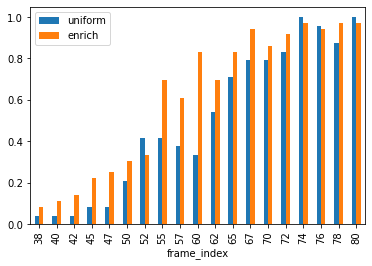

In [53]:
all_data.plot.bar()

<AxesSubplot:xlabel='frame_index'>

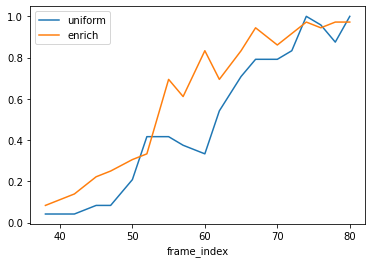

In [54]:
all_data.plot()

# V1 - Data analysis 03/17/2024 : look at survey one (1-12) and two (12-24)

In [19]:
raw_data = pd.read_csv(raw_csv_save_path)

In [20]:
# Separate data for tail size 5 and tail size 10
tail_size_5_uniform_id = ["jafyoxyp", "cpjqwncf", "tpcmympo"]
tail_size_5_enrich_id = ["coyatbri", "mkzyngfl", "qtcbfunj", "rxvkdfak", "fqnoxxhg"]

tail_size_10_uniform_id = ["iewokwah", "xbnwovwi", "jlflqtkp"]
tail_size_10_enrich_id = ["odpavqyq", "qevypgjf", "jmdnxpau"]

In [21]:
uniform_5_record = raw_data.loc[raw_data['AssignmentId'].isin(tail_size_5_uniform_id)]
enrich__5_record = raw_data.loc[raw_data['AssignmentId'].isin(tail_size_5_enrich_id)]

uniform_10_record = raw_data.loc[raw_data['AssignmentId'].isin(tail_size_10_uniform_id)]
enrich_10_record = raw_data.loc[raw_data['AssignmentId'].isin(tail_size_10_enrich_id)]

In [22]:
def add_test_img_name(df):
    df['test_img_name'] = df.test_img.str. \
    split('/').str[-1].str.split("_").str[-1].str.split(".").str[0]

    # Only take the columns we need
    df = df[["worker_response", "test_img_name", "ResponseTime"]]
    df["test_img_name"] = df["test_img_name"].astype(int)
    df = df.sort_values(by=["test_img_name"])
    df["ResponseTime"] = df["ResponseTime"].astype(int)
    df["ResponseTime"] = df["ResponseTime"]/1000
    
    return df

In [23]:
uniform_5 = add_test_img_name(uniform_5_record)
enrich_5 = add_test_img_name(enrich__5_record)

uniform_10 = add_test_img_name(uniform_10_record)
enrich_10 = add_test_img_name(enrich_10_record)

In [30]:
uniform_5.head()

,worker_response,test_img_name,ResponseTime
1707,1,36,1.154
1682,1,36,1.079
34,1,36,5.056
161,1,36,1.574
1700,1,36,1.784


In [55]:
def generate_per_frame_response(df):
    data = df
    
    # Take the columns we need
    data_selected = data[["worker_response", "test_img_name", "ResponseTime"]]
    data_selected.columns = ["worker_response", "frame_index", "ResponseTime"]
    
    data_final = data_selected

    
    # Get the avg RT for each frame
    rt_frame = data_final[["frame_index", "ResponseTime"]]
    rt_frame = rt_frame.groupby(["frame_index"]).sum()
    #print(rt_frame)
    
    # Group by frame index: 
    # response: get counts
    grouped = data_final.groupby(['frame_index','worker_response']).worker_response. \
                            agg('count').to_frame('count').reset_index()
    #print(grouped.head(10))
    #print(grouped)
    
    # responses: get total counts
    grouped_for_counts = grouped[['frame_index','count']]
    total_counts = grouped_for_counts.groupby(['frame_index']).sum()
    
    # Convert user response to int
    grouped["worker_response"] = grouped["worker_response"].astype(int)
    
    # responses: select the counts where worker response is 2
    worker_response_selected = grouped[grouped['worker_response'] == 2]
    worker_response_selected.columns = ["frame_index", "worker_response", "person_b_counts"]
    worker_response_selected = worker_response_selected[["frame_index", "worker_response", "person_b_counts"]]
    
    person_b_counts = worker_response_selected[["frame_index", "person_b_counts"]]
    
    # responses: merge two frames
    result_df = pd.merge(total_counts, person_b_counts, on="frame_index")
    result_df = pd.merge(result_df, rt_frame, on="frame_index")
    
    # response: convert to probability of choosing person B as the answer
    result_df["prob_b"] = result_df["person_b_counts"]/result_df["count"]
    result_df["avg_rt"] = result_df["ResponseTime"]/(result_df["count"]*1000)
    
    return result_df

In [56]:
result_uniform_5 = generate_per_frame_response(uniform_5)
result_enrich_5 = generate_per_frame_response(enrich_5)

result_uniform_10 = generate_per_frame_response(uniform_10)
result_enrich_10 = generate_per_frame_response(enrich_10)

In [60]:
def plot_curves(uniform, enrich):
    data_prob_uniform = uniform[["frame_index", "prob_b"]]
    data_prob_uniform = data_prob_uniform.set_index('frame_index')
    
    data_prob_enrich = enrich[["frame_index", "prob_b"]]
    data_prob_enrich = data_prob_enrich.set_index('frame_index')
    
    data_prob_uniform.columns = ["uniform"]
    data_prob_enrich.columns = ["enrich"]
    
    all_data = data_prob_uniform.join(data_prob_enrich)
    
    print(all_data)
    
    all_data.plot.bar()
    all_data.plot()
    plt.show()

              uniform    enrich
frame_index                    
38           0.111111       NaN
40           0.055556  0.033333
45           0.111111  0.166667
47           0.222222  0.100000
50           0.388889  0.333333
52           0.555556  0.233333
55           0.388889  0.533333
57           0.444444  0.500000
60           0.500000  0.700000
62           0.611111  0.766667
65           0.888889  0.766667
67           0.833333  0.966667
70           0.833333  0.833333
72           0.888889  0.966667
74           1.000000  0.966667
76           0.944444  0.966667
78           0.888889  1.000000
80           1.000000  0.966667


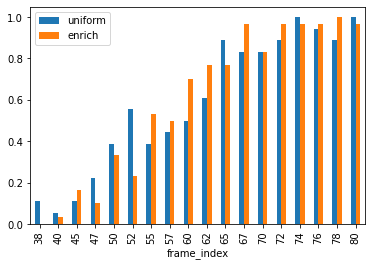

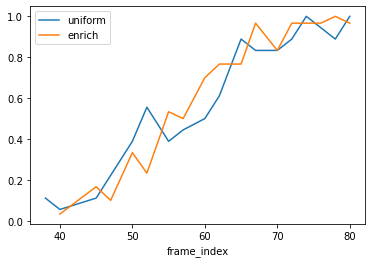

In [61]:
plot_curves(result_uniform_5, result_enrich_5)

              uniform    enrich
frame_index                    
40           0.055556  0.166667
42           0.111111  0.166667
45           0.055556  0.222222
47           0.055556  0.333333
50           0.222222  0.333333
52           0.388889  0.444444
55           0.555556  0.833333
57           0.500000  0.666667
60           0.500000  0.777778
62           0.666667  0.611111
65           0.722222  0.833333
67           0.777778  0.888889
70           0.833333  0.833333
72           0.833333  0.833333
74           1.000000  0.944444
76           1.000000  0.888889
78           0.944444  0.944444
80           1.000000  0.944444


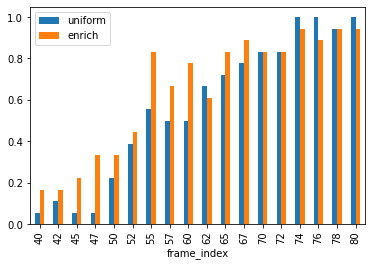

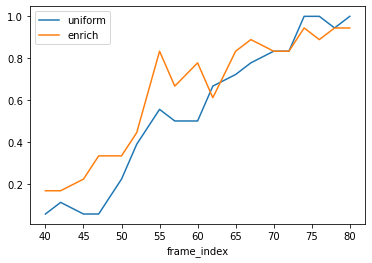

In [62]:
plot_curves(result_uniform_10, result_enrich_10)